In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

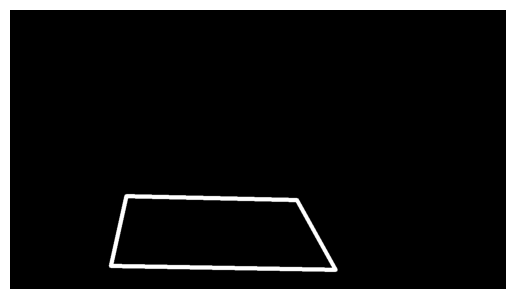

In [10]:
image = np.zeros((720, 1280, 3), np.uint8)
H, W, _ = image.shape

# 이미지 중점
cx, cy = W / 2, H / 2

image_points = np.array([
    [300, 480],
    [740, 490],
    [840, 670],
    [260, 660],
]).astype(np.float32).reshape(4, 1, 2)

cv2.polylines(image, [image_points.astype(int)], True, (255, 255, 255), 10)
plt.imshow(image)
plt.axis('off')

world_points = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0]
]).astype(np.float32).reshape(-1, 1, 3)

H, _ = cv2.findHomography(world_points[:, :, :2], image_points)

# 소실점 추출
# vx = H @ np.array([1, 0, 0]).reshape(3, 1)
# vy = H @ np.array([0, 1, 0]).reshape(3, 1)

# vx = vx.flatten()
# vy = vy.flatten()
vx = H[:, 0]
vy = H[:, 1]

# 주점을 빼서 좌표계 정규화 (동차 좌표계 처리)
x1, y1 = vx[0]/vx[2] - cx, vx[1]/vx[2] - cy
x2, y2 = vy[0]/vy[2] - cx, vy[1]/vy[2] - cy


In [4]:
x1, y1, x2, y2

(np.float64(32597.142857143284),
 np.float64(868.571428571436),
 np.float64(-215.87301587301585),
 np.float64(-438.5714285714292))

In [5]:

# 5. 초점 거리 f 추정
# f^2 + (x1*x2 + y1*y2) = 0
f_sq = -(x1 * x2 + y1 * y2)

if f_sq > 0:
    f = np.sqrt(f_sq)
    print(f"추정된 초점 거리 (f): {f}")
else:
    print("소실점 배치가 적절하지 않아 f를 구할 수 없습니다.")
    f = W


추정된 초점 거리 (f): 2723.559096046928


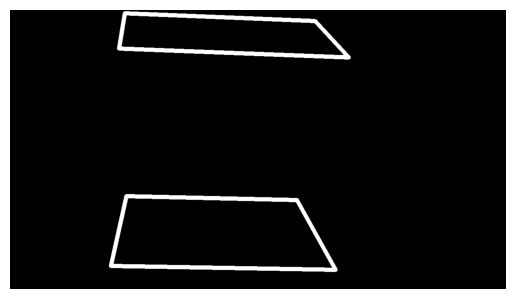

In [11]:

# 3. 내부 파라미터 행렬 K 및 수직 소실점 Vz 계산
K = np.array([
    [f, 0, cx],
    [0, f, cy],
    [0, 0, 1]
], dtype=np.float32)

dist_coeffs = np.zeros((4, 1))
success, rvec, tvec = cv2.solvePnP(world_points, image_points, K, dist_coeffs)

dst = image.copy()
# 5. 정육면체 윗면 4개 점의 3D 월드 좌표 (높이 Z=1 추가)
world_points2 = world_points.copy()
world_points2[:, :, 2] += -1

# 6. 도출된 외부 파라미터를 이용해 윗면 3D 좌표를 2D 이미지 좌표로 투영
image_points2, _ = cv2.projectPoints(world_points2, rvec, tvec, K, dist_coeffs)


cv2.polylines(dst, [image_points2.astype(int)], True, (255, 255, 255), 10)

plt.imshow(dst)
plt.axis('off')
plt.show()

In [12]:
vy

array([-103.3655706 ,   19.14893617,   -0.24371373])